In [1]:
include("EMREfunctionsCompleteSS.jl");

  Activating project at `~/Documents/EMRE Julia Package`


In [2]:
function createSubSpecies(symbol::Symbol, voxelNum::Int)
    subSymbol =  string(string(symbol)[1], string(voxelNum))
    return Symbol(subSymbol)
end;

In [3]:
function createSubRate(symbol::Symbol, voxelNum::Int)
    subSymbol =  string(string(symbol), string(voxelNum))
    return Symbol(subSymbol)
end;

In [4]:
function createSubDiffRate(symbol::Symbol)
    subSymbol =  string("d", string(symbol))
    return Symbol(subSymbol)
end;

In [5]:
struct VoxelReaction
    rxn::Reaction
    voxelNums::Vector{Int}
    voxelRates::Vector{Float64}
end

In [6]:
struct VoxelSpecies
    speciesName::Num
    voxelsNums::Vector{Int}
    initConds::Vector{Float64}
end;


In [7]:
struct DiffReaction
    speciesName::Num
    voxelPairs::Vector{}
    voxelRates::Vector{Float64}
end;

In [8]:
@kwdef struct SpatialSystem
    sysSpecies::Vector{VoxelSpecies}
    sysReactions::Vector{VoxelReaction}
    sysDiffReactions::Vector{DiffReaction}
    numVoxels::Int
end;

In [9]:
## adds all subspecies of a given species to appropriate voxels
function addSpecies(rn::ReactionSystem, species::VoxelSpecies, icsDict)
    i = 1;
    for voxelNum in species.voxelsNums
        subSpeciesSymb = createSubSpecies(Symbol(species.speciesName), voxelNum)
        subSpecies = (@species ($subSpeciesSymb)(t))[1]
        
        addspecies!(rn, subSpecies)
        icsDict[subSpecies] = species.initConds[i]
        i += 1
    end;
end;

In [10]:
## adds reaction (non-diffusive) to appropriate voxels
function addSystemReaction(rn::ReactionSystem, reaction::VoxelReaction, paramsDict)
    i = 1;
    for voxelNum in reaction.voxelNums
        voxelSubstrates = [];
        for substrate in reaction.rxn.substrates
            subSpeciesSymb = createSubSpecies(Symbol(substrate), voxelNum)
            subSpecies = (@species ($subSpeciesSymb)(t))[1]
            push!(voxelSubstrates, subSpecies)
            addspecies!(rn, subSpecies)
        end;
        voxelProducts = [];
        for product in reaction.rxn.products
            prodSpeciesSymb = createSubSpecies(Symbol(product), voxelNum)
            prodSpecies = (@species ($prodSpeciesSymb)(t))[1]
            push!(voxelProducts, prodSpecies)
            addspecies!(rn, prodSpecies)
        end;

        if length(reaction.voxelRates) == 1
            react = Reaction(reaction.rxn.rate, voxelSubstrates, voxelProducts, reaction.rxn.substoich, reaction.rxn.prodstoich)
            addreaction!(rn, react)
            addparam!(rn, reaction.rxn.rate)
            paramsDict[reaction.rxn.rate] = reaction.voxelRates[1]
        else
            rateSymb = createSubRate(Symbol(reaction.rxn.rate), voxelNum)
            rate = (@parameters $rateSymb)[1]
            react = Reaction(rate, voxelSubstrates, voxelProducts, reaction.rxn.substoich, reaction.rxn.prodstoich)
            addreaction!(rn, react)
            addparam!(rn, rate)
            paramsDict[rate] = reaction.voxelRates[i]
        end;
        i += 1
    end;
    addparam!(rn, reaction.rxn.rate); ## assuming rate is the same across voxels, move up into for loop if this changes to different rates
end;

In [11]:
## adds diffusion reactions for a species to appropriate voxels
function addSpeciesDiffusion(rn::ReactionSystem, diff::DiffReaction, paramsDict)
    i = 1;
    for pair in diff.voxelPairs
        subSpeciesSymb1 = createSubSpecies(Symbol(diff.speciesName), pair[1]);
        subSpecies1 = (@species ($subSpeciesSymb1)(t))[1];
        subSpeciesSymb2 = createSubSpecies(Symbol(diff.speciesName), pair[2]);
        subSpecies2 = (@species ($subSpeciesSymb2)(t))[1];
    
        addspecies!(rn, subSpecies1);
        addspecies!(rn, subSpecies2);

        rateSymb = createSubDiffRate(Symbol(diff.speciesName));

        if length(diff.voxelRates) == 1
            rate = (@parameters $rateSymb)[1]
            react1 = Reaction(rate, [subSpecies1], [subSpecies2]);
            addreaction!(rn, react1);
            addparam!(rn, rate);
            paramsDict[rate] = diff.voxelRates[1]

            if pair[3] == true ## if diffusion is bidirectional
                react2 = Reaction(rate, [subSpecies2], [subSpecies1]);
                addreaction!(rn, react2);
            end;
        else
            ## can't do this yet
        end;
    end;
end;

In [12]:
function buildSystem(sys::SpatialSystem)

    rn = @reaction_network begin
    end;

    icsDict = Dict([]);
    paramsDict = Dict([]);

    for species in sys.sysSpecies
        addSpecies(rn, species, icsDict)
    end;
    for rx in sys.sysReactions
        addSystemReaction(rn, rx, paramsDict)
    end;
    for dRx in sys.sysDiffReactions
        addSpeciesDiffusion(rn, dRx, paramsDict)
    end;

    return rn, icsDict, paramsDict;
end;

In [13]:
## a function that builds the spatial system and sets up the ics and params for EMRE functions
function getSysICsParams(sys::SpatialSystem)

    rn, icsDict, paramsDict = buildSystem(sys);
    
    ics = [];
    for species in rn.species
        push!(ics, icsDict[species]);
    end;
    params = [];
    for param in rn.ps
        if param in keys(paramsDict)
            push!(params, paramsDict[param]);
        else
            push!(params, 0)
        end;
    end;

    return rn, ics, params;
end;


## Testing ##

In [52]:
# @species A B C
# # @parameters k₁ k₂
# @variables t

# sys = SpatialSystem(sysSpecies = [
#                         VoxelSpecies(A, [1, 2], [4, 2]), 
#                         VoxelSpecies(B, [1, 2], [3, 1]),
#                         VoxelSpecies(C, [1, 2], [2, 0]) ],
#                     sysReactions = [
#                         VoxelReaction((@reaction k₁,A + B --> C), [1, 2], [0.7]),
#                         VoxelReaction((@reaction k₂,C --> A + B), [1, 2], [0.2])],
#                     sysDiffReactions = [
#                         DiffReaction(A, [[1, 2, true]], [0.3]),
#                         DiffReaction(B, [[1, 2, true]], [0.3]),
#                         DiffReaction(C, [[1, 2, true]], [0.3])],
#                     numVoxels = 2,
# );

In [14]:
@species G M R P g
@parameters k₁ k₂ k₃ k₄ k₅ k₆
@variables t

## Nucleus = Voxel 1

sys = SpatialSystem(sysSpecies = [
                        VoxelSpecies(G, [1], [1]),
                        VoxelSpecies(g, [1], [0]),
                        VoxelSpecies(M, [1, 2, 3, 4, 5, 6], [0, 0, 0, 0, 0, 0]),
                        VoxelSpecies(R, [3], [1]),
                        VoxelSpecies(P, [1, 2, 3, 4, 5, 6], [0, 0, 0, 0, 0, 0])
                                ],
                    sysReactions = [
                        VoxelReaction((@reaction k₁, G --> G + M), [1], [0.4]),
                        VoxelReaction((@reaction k₂, M + R --> M + R + P), [3], [0.6]),
                        VoxelReaction((@reaction k₃, P + G --> g), [1], [0.2]),
                        VoxelReaction((@reaction k₄, P + G <-- g), [1], [0.3]),
                        VoxelReaction((@reaction k₅, M --> 0), [1, 2, 3, 4, 5, 6], [0.2]),
                        VoxelReaction((@reaction k₆, P --> 0), [1, 2, 3, 4, 5, 6], [0.2])
                                ],
                    sysDiffReactions = [
                        DiffReaction(M, [[1, 2, false], [1, 6, false], [2, 3, true], [3, 4, true], [4, 5, true], [5, 6, true]], [0.3]),
                        DiffReaction(P, [[1, 2, true], [1, 6, true], [2, 3, true], [3, 4, true], [4, 5, true], [5, 6, true]], [0.3])
                                ],
                    numVoxels = 6);

In [16]:
rn, ics, params = getSysICsParams(sys);
# display(rn.species)
# display(ics)
# display(rn.ps)
# display(params)
tEnd = 500; numSteps = 101; numTrajs = 10000;
volume = 1/(sys.numVoxels);
timePoints, SSAmeans, SS, realizedSS = EMRE(rn, ics, params, volume, tEnd, numSteps, numTrajs);

SymbolicUtils.BasicSymbolic{Real}[G1(t), g1(t), M1(t), M2(t), M3(t), M4(t), M5(t), M6(t), R3(t), P1(t), P2(t), P3(t), P4(t), P5(t), P6(t)][Base.OneTo(15)]

0.0013168406072705807

-0.0010046400379346843

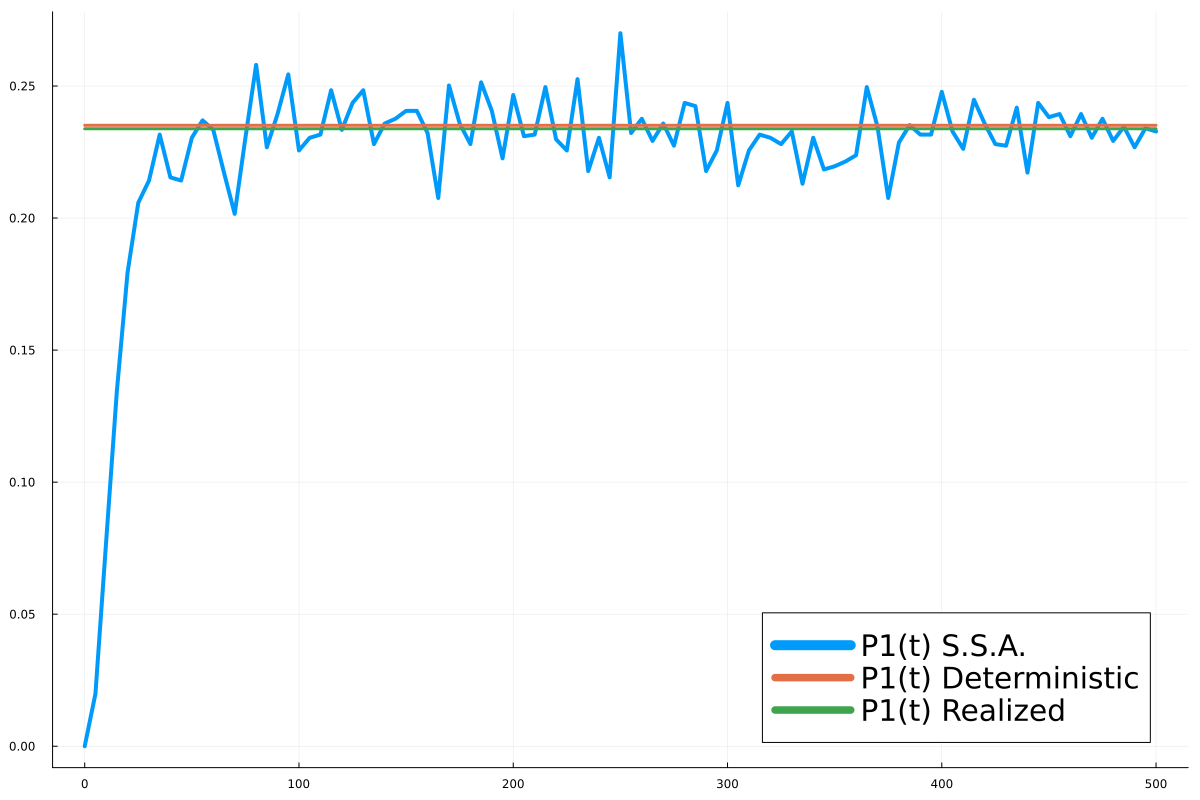

In [22]:
display(rn.species)

i = 10;

display(SS[i] - realizedSS[i])
display(mean(SSAmeans[i,end])-realizedSS[i])

plot(timePoints, [array[i] for array in SSAmeans], lw=4, label=string(rn.species[i], " S.S.A."), size=(1200,800), legendfontsize=20)
plot!([0, tEnd], [SS[i], SS[i]], lw=3, label=string(rn.species[i]," Deterministic"))
plot!([0, tEnd], [realizedSS[i], realizedSS[i]], lw=3, label=string(rn.species[i]," Realized"))


# plot!(timePoints, [array[11] for array in SSAmeans], lw=4, label="P2 S.S.A.", size=(1200,800))
# plot!([0, tEnd], [SS[11], SS[11]], lw=3, label="P2 Deterministic")
# plot!([0, tEnd], [realizedSS[11], realizedSS[11]], lw=3, label="P2 Realized")

In [23]:
println("M concentrations in space")
print("|")
for i in 1:6
    print(string(round(realizedSS[2+i],digits = 3)), " | ")
end;

println("")
println("P concentrations in space")
print("|")
for i in 1:6
    print(string(round(realizedSS[9+i],digits = 3)), " | ")
end;

M concentrations in space
|2.579 | 1.631 | 0.139 | 0.407 | 0.945 | 2.115 | 
P concentrations in space
|0.234 | 0.448 | 0.961 | 0.448 | 0.234 | 0.175 | 

In [67]:
@species A B C
@parameters k₁ k₂ k₃
@variables t

sys = SpatialSystem(sysSpecies = [
                        VoxelSpecies(A, [1,2,3], [4,0,0]), 
                        VoxelSpecies(B, [1,2,3], [3,0,0]),
                        VoxelSpecies(C, [1,2,3], [2,0,0]) ],
                    sysReactions = [
                        VoxelReaction((@reaction k₁,A + B --> C), [1,2,3], [2]),
                        VoxelReaction((@reaction k₂,C --> A + B), [1,2,3], [0.8])],
                    sysDiffReactions = [
                        DiffReaction(A, [[1, 2, true], [2, 3, true]], [0.03]),
                        DiffReaction(B, [[1, 2, true], [2, 3, true]], [0.03]),
                        DiffReaction(C, [[1, 2, true], [2, 3, true]], [0.03])],
                    numVoxels = 3,
);

rn, ics, params = getSysICsParams(sys);

tEnd = 1000; numSteps = 101; numTrajs = 10000;
volume = 1/(sys.numVoxels);

timePoints, SSAmeans, SS, realizedSS = EMRE(rn, ics, params, volume, tEnd, numSteps, numTrajs);

In [29]:
display(rn.species)

SymbolicUtils.BasicSymbolic{Real}[A1(t), A2(t), A3(t), B1(t), B2(t), B3(t), C1(t), C2(t), C3(t)][Base.OneTo(9)]

-0.16554469277630446

0.009558511500770805

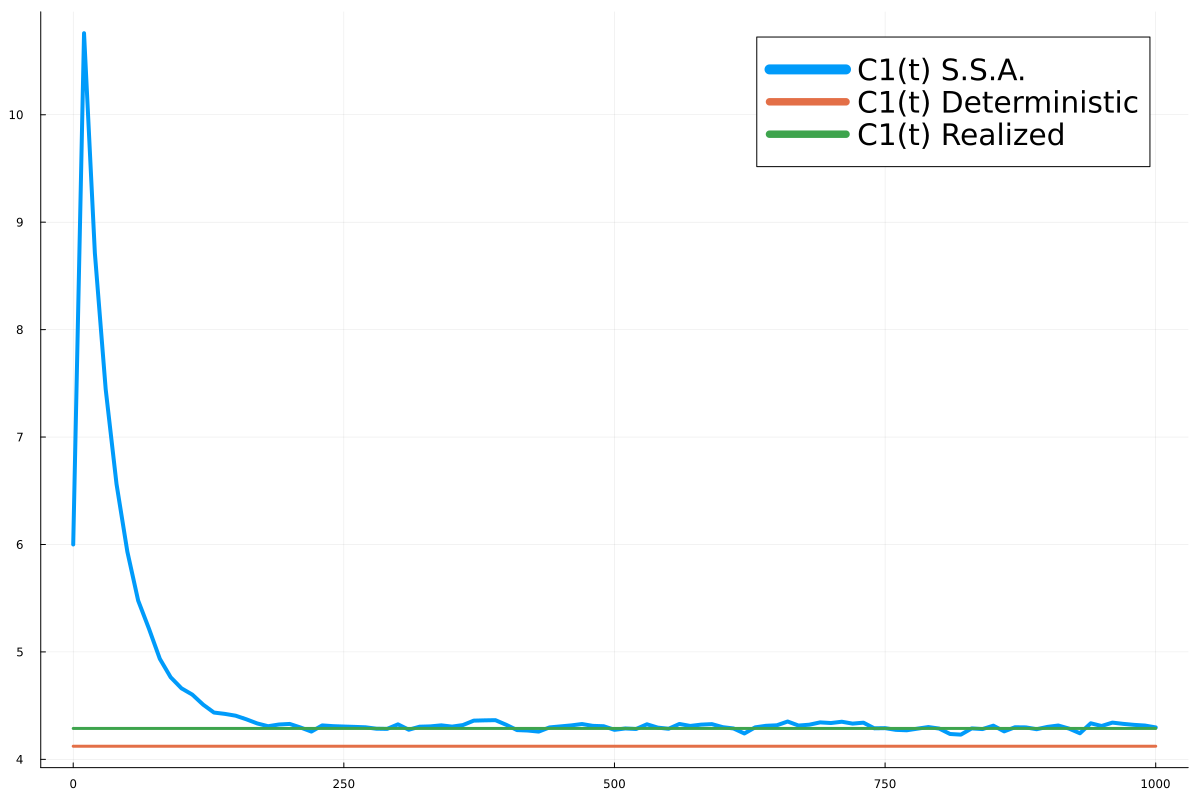

In [68]:
i = 7;
display(SS[i] - realizedSS[i])
display(mean(SSAmeans[i,end])-realizedSS[i])

plot(timePoints, [array[i] for array in SSAmeans], lw=4, label=string(rn.species[i], " S.S.A."), size=(1200,800), legendfontsize=20)
plot!([0, tEnd], [SS[i], SS[i]], lw=3, label=string(rn.species[i]," Deterministic"))
plot!([0, tEnd], [realizedSS[i], realizedSS[i]], lw=3, label=string(rn.species[i]," Realized"))